In this note, we give 3 implementations of the $n$-qubit Toffoli gate, which contains $n-1$ controll qubits, grouped into a register named $x$, and a target qubit $t$.

We first implement the $n$-qubit Toffoli gate naively with depth $n$

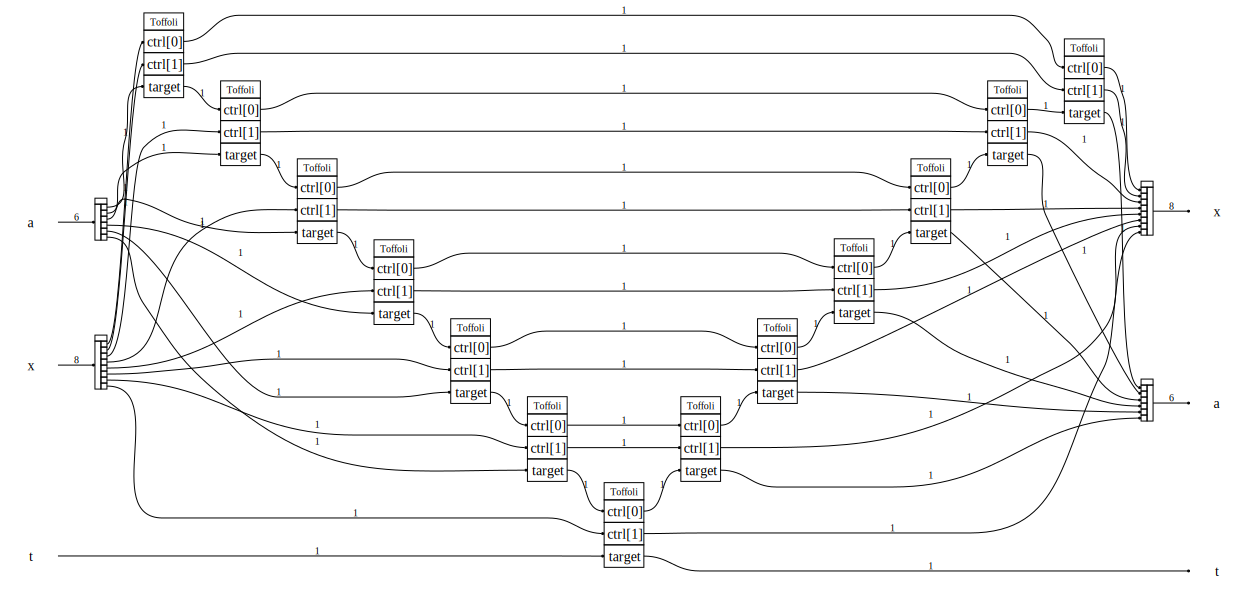

In [1]:
from qualtran import BloqBuilder, QBit, QAny
from qualtran.bloqs.basic_gates import Toffoli
from qualtran.drawing import show_bloq


def n_qubit_toffoli(n: int):
    assert n >= 3
    k = n - 1  # number of controls

    bb = BloqBuilder()

    # Group all controls into one register x of length k
    x = bb.add_register('x', QAny(k))
    t = bb.add_register('t', QBit())

    # Split x into individual control bits
    x_bits = list(bb.split(x))

    # Base case: ordinary Toffoli for n=3 (2 controls)
    if k == 2:
        (x_bits[0], x_bits[1]), t = bb.add(
            Toffoli(), ctrl=[x_bits[0], x_bits[1]], target=t
        )
        x = bb.join(x_bits)
        return bb.finalize(x=x, t=t)

    # For k >= 3, we need (k-2) = (n-3) clean ancillas, grouped into one register a.
    a = bb.add_register('a', QAny(k - 2))
    a_bits = list(bb.split(a))

    # Compute prefix ANDs into ancillas:
    (x_bits[0], x_bits[1]), a_bits[0] = bb.add(
        Toffoli(), ctrl=[x_bits[0], x_bits[1]], target=a_bits[0]
    )
    for i in range(1, k - 2):
        (a_bits[i - 1], x_bits[i + 1]), a_bits[i] = bb.add(
            Toffoli(), ctrl=[a_bits[i - 1], x_bits[i + 1]], target=a_bits[i]
        )

    # Flip target using last ancilla and last control
    (a_bits[k - 3], x_bits[k - 1]), t = bb.add(
        Toffoli(), ctrl=[a_bits[k - 3], x_bits[k - 1]], target=t
    )

    # Uncompute ancillas in reverse
    for i in range(k - 3, 0, -1):
        (a_bits[i - 1], x_bits[i + 1]), a_bits[i] = bb.add(
            Toffoli(), ctrl=[a_bits[i - 1], x_bits[i + 1]], target=a_bits[i]
        )
    (x_bits[0], x_bits[1]), a_bits[0] = bb.add(
        Toffoli(), ctrl=[x_bits[0], x_bits[1]], target=a_bits[0]
    )

    # Re-pack grouped registers
    x = bb.join(x_bits)
    a = bb.join(a_bits)

    return bb.finalize(x=x, t=t, a=a)


# Example
prog = n_qubit_toffoli(9)
show_bloq(prog)


Next, we give an implementation with depth $\log n$, and define it to be a bloq. Without loss of generality, we assume $n$ is a power of $2$. In the end, we provide an example of $n=9$

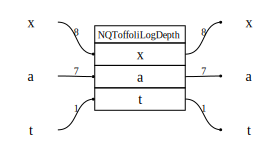

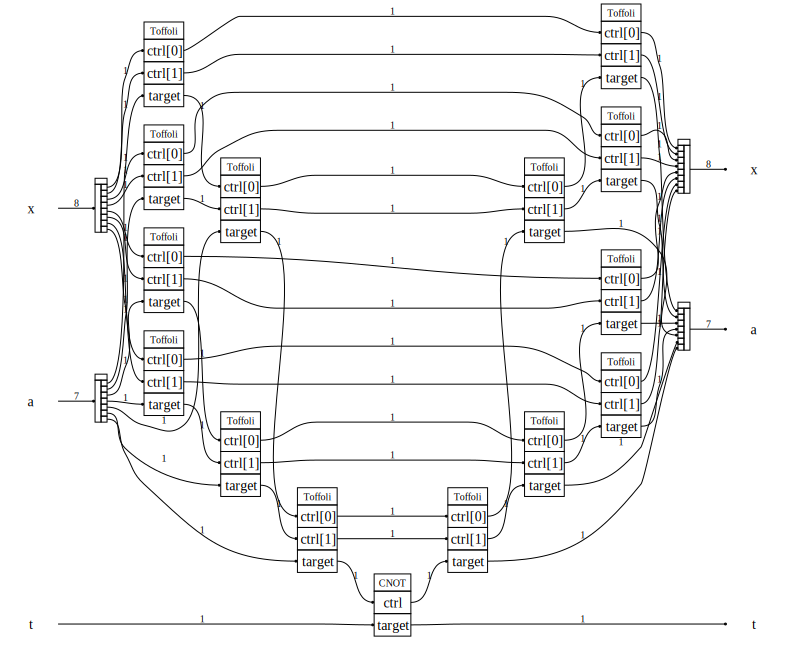

In [2]:
from dataclasses import dataclass
from qualtran import Bloq, BloqBuilder, Signature, Register, QBit, QAny
from qualtran.bloqs.basic_gates import Toffoli, CNOT
from qualtran.drawing import show_bloq


@dataclass(frozen=True)
class NQToffoliLogDepth(Bloq):
    """Log-depth (n-1)-controlled X using a balanced AND tree of Toffolis.

    Inputs/outputs:
      - x : QAny(m)     where m = n-1 (must be power of 2)
      - a : QAny(m-1)   ancilla bus (assumed clean)
      - t : QBit        target

    Implements: t ^= AND(x[0..m-1]) and uncomputes ancillas.
    """

    n: int

    @property
    def m(self) -> int:
        return self.n - 1

    @property
    def signature(self) -> Signature:
        m = self.m
        if self.n < 3:
            raise ValueError("Require n >= 3.")
        if (m & (m - 1)) != 0:
            raise ValueError("Require m=n-1 to be a power of 2.")
        return Signature(
            [
                Register("x", QAny(m)),
                Register("a", QAny(m - 1)),
                Register("t", QBit()),
            ]
        )

    def build_composite_bloq(self, bb: BloqBuilder, **soqs):
        m = self.m

        # Incoming packed registers
        x = soqs["x"]
        a = soqs["a"]
        t = soqs["t"]

        # Split packed registers into per-qubit wires for internal logic
        ctrls = list(bb.split(x))
        a_bits = list(bb.split(a))
        a_off = 0

        # Base case
        if m == 2:
            (ctrls[0], ctrls[1]), t = bb.add(
                Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=t
            )
            x = bb.join(ctrls)
            a = bb.join(a_bits)
            return {"x": x, "a": a, "t": t}

        levels = [ctrls]
        level_starts = []  # start index in a_bits for each level

        level = 0
        while len(levels[level]) > 1:
            prev = levels[level]
            m_level = len(prev) // 2

            start = a_off
            level_starts.append(start)
            curr = a_bits[start : start + m_level]
            a_off += m_level

            for j in range(m_level):
                u = prev[2 * j]
                v = prev[2 * j + 1]
                a_j = curr[j]

                (u, v), a_j = bb.add(Toffoli(), ctrl=[u, v], target=a_j)

                prev[2 * j] = u
                prev[2 * j + 1] = v
                curr[j] = a_j
                a_bits[start + j] = a_j  # keep global pool updated

            levels.append(curr)
            level += 1

        # Apply AND to target: replace old Toffoli(root, |1>) by CNOT(root)
        root = levels[-1][0]
        root, t = bb.add(CNOT(), ctrl=root, target=t)
        levels[-1][0] = root

        # Uncompute the ancilla
        for level in reversed(range(len(levels) - 1)):
            prev = levels[level]
            curr = levels[level + 1]
            start = level_starts[level]
            for j in range(len(curr)):
                u = prev[2 * j]
                v = prev[2 * j + 1]
                a_j = curr[j]

                (u, v), a_j = bb.add(Toffoli(), ctrl=[u, v], target=a_j)

                prev[2 * j] = u
                prev[2 * j + 1] = v
                curr[j] = a_j
                a_bits[start + j] = a_j  # keep global pool updated

        # Re-pack to output registers
        x = bb.join(levels[0])
        a = bb.join(a_bits)
        return {"x": x, "a": a, "t": t}


# Example
Toff9 = NQToffoliLogDepth(n=9)
show_bloq(Toff9)
show_bloq(Toff9.decompose_bloq())


The recent work [GKZ25] gives an $\epsilon$-approximate implementation of the $n$-qubit Toffoli gate using exponentially fewer $T$ gates. The construction is based on the following classical randomized algorithm that computes the OR function: Samples $k=O(\log n)$ subsets of $[n-1]$, computes their parity values, and then applies a $k$-bit OR function together with additional Clifford operations. Implementing the above procedure in superpositions with proper negations yields an approximate implementation of the $n$-qubit Toffoli gate.

Here, we assume the sampling procedure is done, and the $k$ subsets are given as $k$ classical $(n-1)$-bit strings $s_1,\ldots,s_k$, where $[s_i]_j=1$ if and only if $j$ belows to the $i$-th subset. We first prepare the following block that computes $k$ $(n-1)$-bit strings $x_1,\ldots,x_k$, where $[x_i]_j=x_j\cdot [s_i]_j$ for any $i,j$.

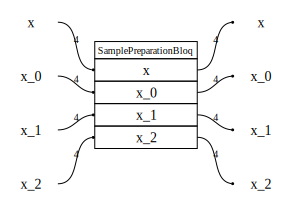

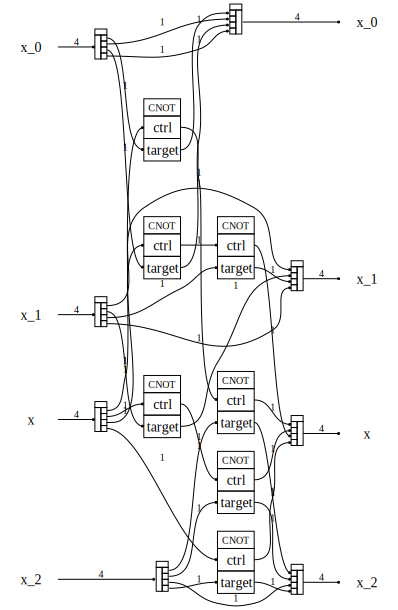

In [3]:
from dataclasses import dataclass
from typing import Tuple, Dict, Any as AnyType

from qualtran import Bloq, BloqBuilder, Signature, Register, QAny
from qualtran.bloqs.basic_gates import CNOT
from qualtran.drawing import show_bloq


@dataclass(frozen=True)
class SamplePreparationBloq(Bloq):
    n: int
    k: int
    # randomly sampled classical subsets: shape (k, n-1), entries are 0/1
    sample_strings: Tuple[Tuple[int, ...], ...]  # length k, each length n-1

    @property
    def signature(self) -> Signature:
        regs = [
            # controls: length n-1 (same as ApproxToffoli.x)
            Register("x", QAny(self.n - 1)),
        ]
        # k output registers, each also length n-1 (same as ApproxToffoli.x_i)
        regs += [Register(f"x_{i}", QAny(self.n - 1)) for i in range(self.k)]
        return Signature(regs)

    def build_composite_bloq(self, bb: BloqBuilder, **soqs) -> Dict[str, AnyType]:
        if len(self.sample_strings) != self.k:
            raise ValueError("sample_strings must have length k.")
        for row in self.sample_strings:
            if len(row) != self.n - 1:
                raise ValueError("Each mask in sample_strings must have length n-1.")

        # Input controls
        x = soqs["x"]
        x_bits = list(bb.split(x))

        # Prepare each sampled subset into x_0, ..., x_{k-1}
        out_regs = []
        for i in range(self.k):
            xi = soqs[f"x_{i}"]
            xi_bits = list(bb.split(xi))

            for j in range(self.n - 1):
                if self.sample_strings[i][j]:
                    # copy x_j into xi_j if sample_strings[i][j] == 1
                    x_bits[j], xi_bits[j] = bb.add(CNOT(), ctrl=x_bits[j], target=xi_bits[j])

            out_regs.append(bb.join(xi_bits))

        x = bb.join(x_bits)

        return {
            "x": x,
            **{f"x_{i}": out_regs[i] for i in range(self.k)},
        }


# Example for this sample preparation subroutine with n=5, k=3
sample_strings = (
    (1, 0, 1, 0),
    (0, 1, 1, 0),
    (1, 1, 0, 1),
)

B = SamplePreparationBloq(n=5, k=3, sample_strings=sample_strings)
show_bloq(B)
show_bloq(B.decompose_bloq())


Using this sample preparation step as a subroutine, we obtain the circuit that approximates the $n$-qubit Toffoli gate.

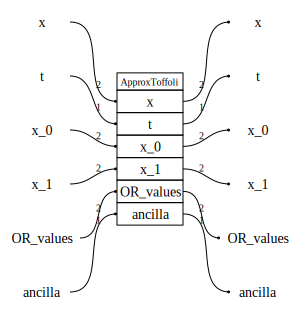

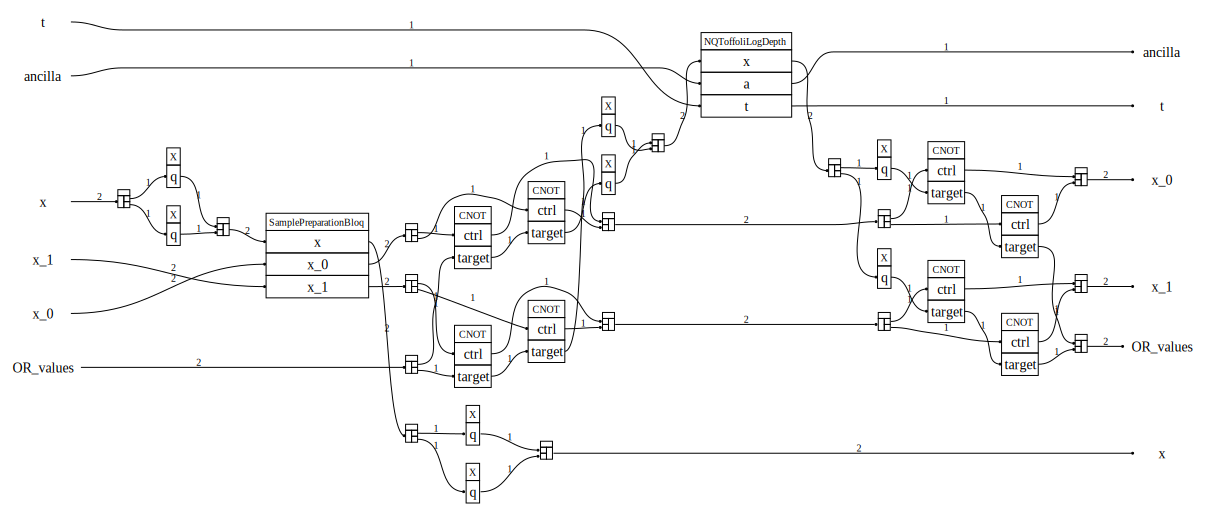

In [4]:
from dataclasses import dataclass
from typing import Tuple, Dict, Any as AnyType

from qualtran import Bloq, BloqBuilder, Signature, Register, QAny, QBit
from qualtran.bloqs.basic_gates import XGate, CNOT
from qualtran.drawing import show_bloq


@dataclass(frozen=True)
class ApproxToffoli(Bloq):
    n: int
    k: int
    sample_strings: Tuple[Tuple[int, ...], ...]

    @property
    def signature(self) -> Signature:
        regs = [
            Register("x", QAny(self.n - 1)),
            Register("t", QBit()),
        ]
        regs += [Register(f"x_{i}", QAny(self.n - 1)) for i in range(self.k)]
        regs += [Register("OR_values", QAny(self.k))]
        regs += [Register("ancilla", QAny(self.k - 1))]   # << renamed here
        return Signature(regs)

    def build_composite_bloq(self, bb: BloqBuilder, **soqs) -> Dict[str, AnyType]:
        n, k = self.n, self.k

        x = soqs["x"]
        t = soqs["t"]

        OR_pack = soqs["OR_values"]
        OR_regs = list(bb.split(OR_pack))  # length k, each is QBit

        # 1) Flip x
        x_bits = list(bb.split(x))
        for j in range(n - 1):
            x_bits[j] = bb.add(XGate(), q=x_bits[j])
        x = bb.join(x_bits)

        # 2) Sample prep
        sp = SamplePreparationBloq(n=n, k=k, sample_strings=self.sample_strings)
        sp_kwargs = {"x": x}
        for i in range(k):
            sp_kwargs[f"x_{i}"] = soqs[f"x_{i}"]
        sp_out = bb.add(sp, **sp_kwargs)
        x = sp_out[0]
        x_regs = list(sp_out[1:])

        # 3) Parity compute
        for i in range(k):
            xi = x_regs[i]
            oi = OR_regs[i]

            xi_bits = list(bb.split(xi))
            for j in range(n - 1):
                xi_bits[j], oi = bb.add(CNOT(), ctrl=xi_bits[j], target=oi)

            x_regs[i] = bb.join(xi_bits)
            OR_regs[i] = oi

        # 4) k-control Toffoli
        and_k = NQToffoliLogDepth(n=k + 1)
        ancilla = soqs["ancilla"]        # << renamed here

        for i in range(k):
            OR_regs[i] = bb.add(XGate(), q=OR_regs[i])

        OR_pack = bb.join(OR_regs)
        OR_pack, ancilla, t = bb.add(and_k, x=OR_pack, a=ancilla, t=t)   # << renamed here

        OR_regs = list(bb.split(OR_pack))
        for i in range(k):
            OR_regs[i] = bb.add(XGate(), q=OR_regs[i])

        # 5) Uncompute parity
        for i in reversed(range(k)):
            xi = x_regs[i]
            oi = OR_regs[i]

            xi_bits = list(bb.split(xi))
            for j in range(n - 1):
                xi_bits[j], oi = bb.add(CNOT(), ctrl=xi_bits[j], target=oi)

            x_regs[i] = bb.join(xi_bits)
            OR_regs[i] = oi

        OR_pack = bb.join(OR_regs)

        # 6) Unflip x
        x_bits = list(bb.split(x))
        for j in range(n - 1):
            x_bits[j] = bb.add(XGate(), q=x_bits[j])
        x = bb.join(x_bits)

        return {
            "x": x,
            "t": t,
            "OR_values": OR_pack,
            "ancilla": ancilla,            # << renamed here
            **{f"x_{i}": x_regs[i] for i in range(k)},
        }


# Example: n = 3, k = 2
n = 3
k = 2
sample_strings = (
    (1, 0),
    (0, 1),
)

B = ApproxToffoli(n=n, k=k, sample_strings=sample_strings)
show_bloq(B)
show_bloq(B.decompose_bloq())


Finally, we test the correctness of the algorithm on classical inputs/outputs. In the example below, we set $n=17$ and $k=4$. We randomly sample $x$ and sample_strings every time. The expected error probability is $2^{-k}=1/16$.

In [6]:
import random

# n = 17 (16 controls), k = 4
n = 17
k = 4
m = n - 1
ALL_ONES = (1 << m) - 1

def random_sample_string(width: int) -> tuple[int, ...]:
    return tuple(random.randint(0, 1) for _ in range(width))

def ideal_toffoli_t(x_int: int, t_in: int) -> int:
    # Ideal 16-controlled Toffoli
    return t_in ^ int(x_int == ALL_ONES)

# ----------------------------
# Single randomized example
# ----------------------------

# Randomly sample x
x_int = random.randint(0, ALL_ONES)
t_in = 0

# Fresh random sample strings
sample_strings = tuple(random_sample_string(m) for _ in range(k))

B = ApproxToffoli(n=n, k=k, sample_strings=sample_strings)

out = B.call_classically(
    x=x_int,
    t=t_in,
    x_0=0,
    x_1=0,
    x_2=0,
    x_3=0,
    OR_values=0,
    ancilla=0,
)

t_out = out[1]
t_expected = ideal_toffoli_t(x_int, t_in)

print("Single randomized test case")
print(f"  x (binary) = {x_int:016b}")
print(f"  sample_strings   = {sample_strings}")
print(f"  Approx t  = {t_out}")
print(f"  Ideal t   = {t_expected}")
print(f"  MATCH     = {t_out == t_expected}")


Single randomized test case
  x (binary) = 1000100111111100
  sample_strings   = ((1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0), (0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1), (0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0), (0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0))
  Approx t  = 1
  Ideal t   = 0
  MATCH     = False
